In [8]:
import numpy
import matplotlib.pyplot as plt

from objects import NormalModel, TransitionModel
from utils import rand_obs, rand_nnd, model_extract, random_nan
from dataload import weather_dataframe
from config import CSV_PATH

In [9]:
dataset = weather_dataframe(CSV_PATH)

data_array = dataset[["humidity(%)", "TEMPCORR"]].to_numpy(dtype=float)

# data_array = random_nan(data_array[0:3], 3)

# data_array[numpy.array([0,1,2])]

In [10]:
data_array = numpy.expand_dims(numpy.random.uniform(size=50), axis=1)

In [11]:
# Model's observable period
PERIOD = 50

# Model's predicted period
BEYOND_PERIOD = 10


# Dimensional parameters
N = 1
M = data_array.shape[1]

In [12]:
from components import ComponentFactory
import numpy

factory = ComponentFactory()

m_1 = factory.polynomial(1)
m_2 = factory.harmonics(1,5)

f_1_1 = m_1.transition
f_2_1 = m_1.covariate(m_2.dimension)
f_1_2 = m_2.covariate(m_1.dimension)
f_2_2 = m_2.transition

h_1 = m_1.covariate(M, [0])
h_2 = m_2.covariate(M, [0])

F = numpy.block([[f_1_1, f_1_2],[f_2_1, f_2_2]])
H = numpy.block([[h_1, h_2]])

P: "int" = F.shape[0]

In [13]:
# Primordial model setting
n0 = rand_obs((P,N))
n0.covariance = rand_nnd(P, 1)

# Evolver setting
b_e = numpy.zeros((P, N)) # p by n
a_e = F # p by p
v_e = numpy.eye(P) * 1
te = TransitionModel(b_e, a_e, v_e)

# Predictor setting
b_p = numpy.zeros((M, N)) # m by n
a_p = H # m by p
v_p = numpy.eye(M) * 50
tp = TransitionModel(b_p, a_p, v_p)

In [14]:
import funcs
import memory

prime_memory = memory.PrimeMemoryDLM(
    forward_period=PERIOD,
    beyond_period=BEYOND_PERIOD,
    primordial_model=n0,
    evolvers=[te],
    observers=[tp],
    observations=data_array
)

In [15]:
new_memory = memory.MemoryDLM()
new_memory = funcs.forward(prime_memory=prime_memory, memory=new_memory)
new_memory = funcs.backward(prime_memory=prime_memory, memory=new_memory)
new_memory = funcs.beyond(prime_memory=prime_memory, memory=new_memory)

TypeError: forward() missing 1 required positional argument: 'memory'

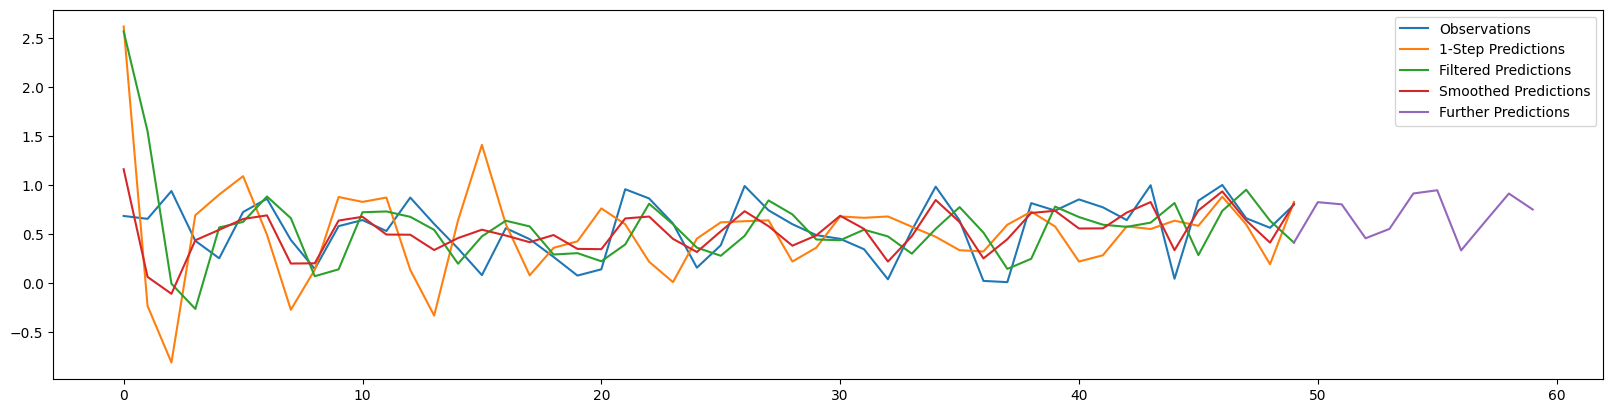

In [ ]:
index=0

fig, ax = plt.subplots()

x0_data = list(range(len(data_array)))
x1_data = list(range(PERIOD))
x2_data = list(range(PERIOD-1, PERIOD + BEYOND_PERIOD))

y1_data = data_array[:,index]
y2_data = list(model_extract(new_memory.evolved_spaces, index))
y3_data = list(model_extract(new_memory.filtered_spaces, index))
y4_data = list(model_extract(new_memory.smoothed_spaces, index))
y5_data = list(model_extract(new_memory.predicted_spaces, index))

ax.plot(x0_data, y1_data, label="Observations")
ax.plot(x1_data, y2_data, label="1-Step Predictions")
ax.plot(x1_data, y3_data, label="Filtered Predictions")
ax.plot(x1_data, y4_data, label="Smoothed Predictions")
ax.plot(x2_data, y5_data, label="Further Predictions")

ax.legend()
fig.set_figwidth(20)
plt.show()